In [93]:
import pandas as pd
import datetime
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import ComplementNB
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.inspection import plot_partial_dependence
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import plot_partial_dependence
import statsmodels.api as sm
import seaborn as sns
import pickle as pkl

In [48]:
df = pd.read_csv('sf.csv')

In [49]:
conditions = [
    (df.subject_race == 'white') & (df.subject_sex == 'female'),
    (df.subject_race == 'hispanic') & (df.subject_sex == 'female'),
    (df.subject_race == 'black') & (df.subject_sex == 'female'),
    (df.subject_race == 'asian/pacific islander') & (df.subject_sex == 'female'),
    (df.subject_race == 'white') & (df.subject_sex == 'male'),
    (df.subject_race == 'hispanic') & (df.subject_sex == 'male'),
    (df.subject_race == 'black') & (df.subject_sex == 'male'),
    (df.subject_race == 'asian/pacific islander') & (df.subject_sex == 'male')]
choices = ['white_female', 'hispanic_female', 'black_female','asian_female',
          'white_male', 'hispanic_male', 'black_male','asian_male']
df['demographic'] = np.select(conditions, choices, default='other')

In [50]:
df.columns

Index(['raw_row_number', 'date', 'time', 'location', 'lat', 'lng', 'district',
       'subject_age', 'subject_race', 'subject_sex', 'type', 'arrest_made',
       'citation_issued', 'warning_issued', 'outcome', 'contraband_found',
       'search_conducted', 'search_vehicle', 'search_basis', 'reason_for_stop',
       'raw_search_vehicle_description', 'raw_result_of_contact_description',
       'demographic'],
      dtype='object')

In [51]:
df_to_model = df[['subject_age','demographic']]
target = df.arrest_made

In [62]:
df_to_mod_dummies = pd.get_dummies(df_to_model.demographic)

In [63]:
df_to_mod_dummies['age'] = df_to_model.subject_age

In [64]:
df_to_mod_dummies.columns

Index(['asian_female', 'asian_male', 'black_female', 'black_male',
       'hispanic_female', 'hispanic_male', 'other', 'white_female',
       'white_male', 'age'],
      dtype='object')

In [81]:
X = df_to_mod_dummies.dropna()
y = target.dropna().sample(n=846182)

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [83]:
clf = LogisticRegression(penalty='l1',random_state=42, solver='liblinear').fit(X_train, y_train)

In [84]:
clf.score(X_test,y_test)

0.9865419341419833

In [85]:
np.exp(clf.coef_)

array([[0.11399577, 0.11785484, 0.11624654, 0.11292663, 0.1165236 ,
        0.11749821, 0.11198771, 0.11482685, 0.11544204, 0.99822835]])

In [86]:
original_variables = list(X)
zipped_together = list(zip(original_variables, clf.coef_[0]))
coefs = [list(x) for x in zipped_together]
coefs = pd.DataFrame(coefs, columns=["Variable", "Coefficient"])
coefs.sort_values(by=["Coefficient"], axis=0, inplace=True, ascending=False)
coefs.drop_duplicates(keep=False)
coefs

,Variable,Coefficient
9,age,-0.001773
1,asian_male,-2.138302
5,hispanic_male,-2.141332
4,hispanic_female,-2.149661
2,black_female,-2.152042
8,white_male,-2.158987
7,white_female,-2.164330
0,asian_female,-2.171594
3,black_male,-2.181017
6,other,-2.189366


In [87]:
coefs.sort_index()

,Variable,Coefficient
0,asian_female,-2.171594
1,asian_male,-2.138302
2,black_female,-2.152042
3,black_male,-2.181017
4,hispanic_female,-2.149661
5,hispanic_male,-2.141332
6,other,-2.189366
7,white_female,-2.164330
8,white_male,-2.158987
9,age,-0.001773


In [90]:
df.raw_search_vehicle_description.value_counts()

No Search                                                                                                                   851482
Vehicle Inventory, Negative Result                                                                                           19154
Searched as a result of Probation or Parole Condition                                                                        13800
Search without Consent, Positive Result                                                                                       6179
Search Incident to Arrest, Negative Result                                                                                    4255
Search with Consent, Negative Result                                                                                          4175
Search without Consent, Negative Result                                                                                       4011
Search Incident to Arrest, Positive Result                                         

In [91]:
consent = df[df.raw_search_vehicle_description == 'Search with Consent, Positive Result'] 

In [94]:
df.groupby(['search_vehicle','arrest_made']).mean().unstack()

lat                    lng             subject_age  \
arrest_made         False      True        False       True        False   
search_vehicle                                                             
False           37.763165  37.762670 -122.429955 -122.429593   38.193775   
True            37.757894  37.758115 -122.417417 -122.422426   31.877569   

                          citation_issued           warning_issued            \
arrest_made         True            False     True           False     True    
search_vehicle                                                                 
False           35.955227        0.717611  0.010789       0.274607  0.001481   
True            33.683059        0.515623  0.000972       0.293030  0.000278   

               search_conducted        
arrest_made               False True   
search_vehicle                         
False                       0.0   0.0  
True                        1.0   1.0

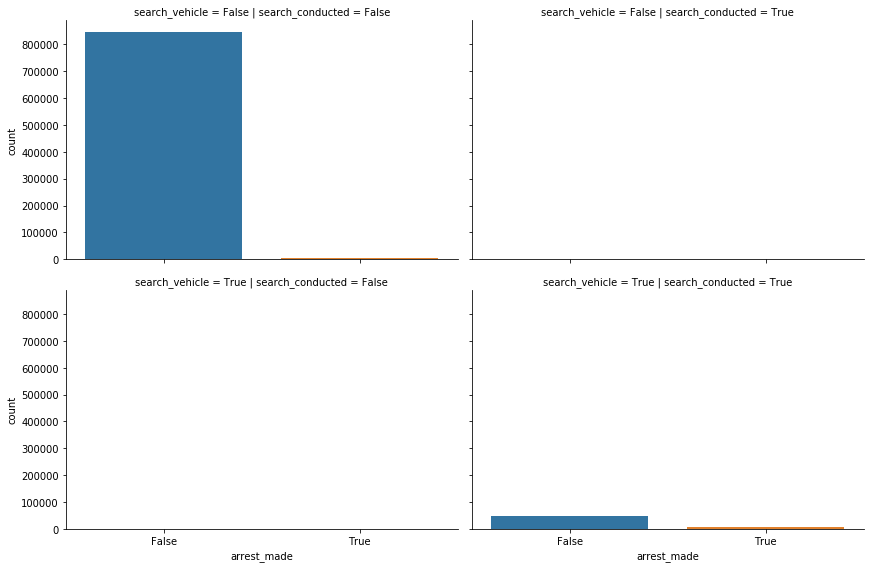

In [97]:
g = sns.factorplot(x='arrest_made', row='search_vehicle', col='search_conducted', data=df,
               kind='count', size=4, aspect=1.5)

In [112]:
blk_total = df[df.subject_race == 'black']

In [113]:
blk_total.shape

(152196, 23)

In [114]:
searched = df[df.search_conducted == True]

In [128]:
blk_searched = searched[searched.subject_race == 'black']
wht_searched = searched[searched.subject_race == 'white']

In [130]:
blk_searched.shape

(23622, 23)

In [131]:
wht_searched.shape

(11707, 23)

In [133]:
23622 / 152196

0.15520775841677836

In [134]:
11707 / 152196

0.0769205498173408

In [118]:
blk_searched.outcome.value_counts()

citation    10251
warning      8019
arrest       2573
Name: outcome, dtype: int64

In [136]:
wht_searched.outcome.value_counts()

citation    5493
warning     2288
arrest      2071
Name: outcome, dtype: int64

In [137]:
2071 / 11707

0.17690270778166908

In [119]:
2573 / 23622

0.1089238845144357

In [120]:
P = np.asarray([.16, .84, .11, .89]).reshape(2,2)

In [122]:
step_one = [1,0]

In [123]:
step_two = np.dot(step_one, P)

In [124]:
step_two

array([0.16, 0.84])

In [125]:
steady = np.dot(step_one, np.linalg.matrix_power(P,100))

In [126]:
steady

array([0.11578947, 0.88421053])

In [138]:
X = np.asarray([.8, .92, .18, .82]).reshape(2,2)

In [142]:
first_step = [1,0]

In [143]:
steady_w = np.dot(first_step, np.linalg.matrix_power(X,100))

In [144]:
steady_w

array([1.65752929e+08, 3.84051977e+08])